In [47]:
from optexec.execution import AC, TWAP, GLOBE
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from optexec.dataloader import OnlineData
from IPython.display import clear_output

In [42]:
def calc_ACPR(  T: int,
                W: np.ndarray, 
                strategy: str,
                start: int, 
                stop: int, 
                num: int,  
                file1: str, #ask
                file2: str, #bid
                rounds_for_est: int,
                skip: int = 0, 
                **params) -> np.ndarray:

    ELL = np.linspace(start = start, stop = stop, num = num, endpoint = True, dtype = int)
    ACPR = []
    if strategy == 'GLOBE':

        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            args = {'T': T, 'W': W, 'L': L, **params}
            
            globe = GLOBE(**args)
            globe.estimate_parameters(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=rounds_for_est + W.shape[0] + 1)
            globe.Mr = globe.M
            # print(len(globe.M))

            orderbook_ask.close()
            orderbook_bid.close()

            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            ACPR_globe = globe.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=rounds_for_est)
            orderbook_ask.close()
            orderbook_bid.close()
            ACPR.append(ACPR_globe)

        ACPR = np.array(ACPR)
    if strategy == 'GLOBE+':

        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            args = {'T': T, 'W': W, 'L': L, **params}
            
            globe = GLOBE(**args)
            globe.estimate_parameters(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask,
                                       rounds_for_est=rounds_for_est + W.shape[0] + 1)
            globe.Mr = globe.M
            # print(len(globe.M))

            orderbook_ask.close()
            orderbook_bid.close()

            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            ACPR_globe = globe.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask,
                                                  rounds_for_est=rounds_for_est, model = 'plus')
            orderbook_ask.close()
            orderbook_bid.close()
            ACPR.append(ACPR_globe)

        ACPR = np.array(ACPR)
    if strategy == 'TWAP':
        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)


            twap = TWAP(T, L , W)
            ACPR_twap = twap.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, skip_rounds=rounds_for_est)
            orderbook_ask.close()
            orderbook_bid.close()
            ACPR.append(ACPR_twap)

        ACPR = np.array(ACPR)

    if strategy == 'AC':
        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            args = {'T': T, 'W': W, 'L': L, **params}
            ac = AC(**args)
            ACPR_ac = ac.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=rounds_for_est)
            ACPR.append(ACPR_ac)
            orderbook_ask.close()
            orderbook_bid.close()
        ACPR = np.array(ACPR) 
    return ACPR


def plot_ACPR(start, stop, num, ACPR, legends, filename):
    ELL = np.linspace(start = start, stop = stop, num = num, endpoint = True, dtype = int)
    sns.set(rc = {"figure.figsize":(16, 9)})
    for acpr, legend in zip(ACPR, legends):
        plt.plot(ELL, acpr,'-', label = legend)

    plt.xlabel('L')
    plt.ylabel(f'ACPR')
    plt.grid(True)
    plt.legend()
    plt.savefig(filename)
    plt.show()

def plot_ACPR_RI(start, stop, num, ACPR, RI, legends, filename, title = None):

    ELL = np.linspace(start = start, stop = stop, num = num, endpoint = True, dtype = int)

    sns.set_theme(style="darkgrid")

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 9))

    if title is not None:
        plt.suptitle(title, fontsize=19, fontweight='bold')

    for acpr, legend in zip(ACPR, legends):
        ax1.plot(ELL, acpr,'-', label = legend)
    for ri, legend in zip(RI, legends):
        ax2.plot(ELL, ri,'-', label = legend)

    ax1.set_xlabel('$L$', fontsize=12)
    ax2.set_xlabel('$L$', fontsize=12)

    ax1.set_ylabel('$ACPR$', fontsize=12)
    ax2.set_ylabel('$RI$', fontsize=12)

    # ax1.set_title(names[0], fontsize=14)
    # ax2.set_title(names[1], fontsize=14)

    ax1.legend()
    ax2.legend()

    plt.savefig(filename)
    plt.show()

def calc_all(
                T: int, 
                W: np.ndarray, 
                start: int, 
                stop: int, 
                num: int, 
                file1: str, 
                file2: str, 
                rounds_for_est: int, 
                skip: int = 0, 
                strategies: list = ['TWAP', 'AC', 'GLOBE', 'GLOBE+'],
                **params) -> list:
    
    ACPR = []
    for strategy in strategies:
        
        ACPR.append(calc_ACPR(T = T, W = W, strategy = strategy, 
                              start = start, stop = stop, num = num, skip = skip, 
                              file1 = file1, file2 = file2, rounds_for_est = rounds_for_est, **params[strategy]))
    return ACPR

def calc_and_plot_all(
                        T: int, 
                        W: np.ndarray, 
                        start: int, 
                        stop: int, 
                        num: int, 
                        file1: str, 
                        file2: str, 
                        rounds_for_est: int, 
                        skip: int = 0, 
                        strategies: list = ['TWAP', 'AC', 'GLOBE', 'GLOBE+'],
                        filename: str = 'TWAP_AC_GLOBE.pdf',
                        **params) -> list:
    
    ACPR = calc_all(T, W, start, stop, num, file1, file2, rounds_for_est, skip, strategies, **params)
    legends = strategies
    plot_ACPR(start, stop, num, ACPR, legends, filename)
    return ACPR

def calc_and_plot_all_ACPR_RI(
                        T: int, 
                        W: np.ndarray, 
                        start: int, 
                        stop: int, 
                        num: int, 
                        file1: str, 
                        file2: str, 
                        rounds_for_est: int, 
                        skip: int = 0, 
                        strategies: list = ['TWAP', 'AC', 'GLOBE', 'GLOBE+'],
                        baseline: str = 'TWAP',
                        filename: str = 'TWAP_AC_GLOBE.pdf',
                        title: str = None,
                        **params) -> list:
    
    idx_baseline = strategies.index(baseline)
    # instrument = file1[:11]
    # date = file1[13:23]
    # w = str(W[0])
    # t = str(T)
    ACPR = calc_all(T, W, start, stop, num, file1, file2, rounds_for_est, skip, strategies, **params)
    RI = []

    acpr_baseline = ACPR[idx_baseline]

    for acpr in ACPR:
        RI.append( (acpr_baseline - acpr)/np.abs(acpr_baseline) )

    legends = strategies
    plot_ACPR_RI(start, stop, num, ACPR, RI, legends, filename, title)
    return ACPR, RI

def parser_N(file1, file2, filename1, filename2, skip = 10, MAX_ITER = 10_000, N = 100):

    f1 = open(file1, 'r')
    f2 = open(file2, 'r')

    f3 = open(filename1, 'w')
    f4 = open(filename2, 'w')

    for _ in range(skip):
        line_ask = f1.readline()
        line_bid = f2.readline()

    if line_ask != '' and line_bid != '': 
        f3.write(line_ask)
        f4.write(line_bid)

        for _ in tqdm(range(MAX_ITER)):
            for s in range(N):
                line_ask = f1.readline()
                line_bid = f2.readline()
            if line_ask == '' or line_bid == '':
                break
            f3.write(line_ask)
            f4.write(line_bid)

    f1.close()
    f2.close()
    f3.close()
    f4.close()

In [45]:
file1 = 'optexec/ask1s.tsv'
file2 = 'optexec/bid1s.tsv'
T = 50
W = np.ones(shape = 10, dtype = int) * 500

W_max = 501 #only for GLOBE

lamb = 2*(0.01)
eta = 2*(0.001)
init_sigma = 0.021713089727230926

start = 2
stop = T
num = 49

skip = 0
rounds_for_est = 15

K = 100000.

title = 'ACPR and RI'



params_GLOBE = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma, 'W_max': W_max, 'K': K}
params_GLOBE_plus = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma, 'W_max': W_max, 'K': K}
params_AC = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma}
params_TWAP = {}

default_params = {'T': T, 'W': W, 'start': start, 'stop': stop, 'num': num,
                   'skip': skip, 'rounds_for_est': rounds_for_est, 'file1': file1, 'file2': file2,
                   'filename': 'optexec/TWAP_AC_GLOBE.pdf', 'title': title}
params = {'TWAP': params_TWAP, 'AC': params_AC, 'GLOBE': params_GLOBE, 'GLOBE+': params_GLOBE_plus}

100%|██████████| 49/49 [01:12<00:00,  1.47s/it]


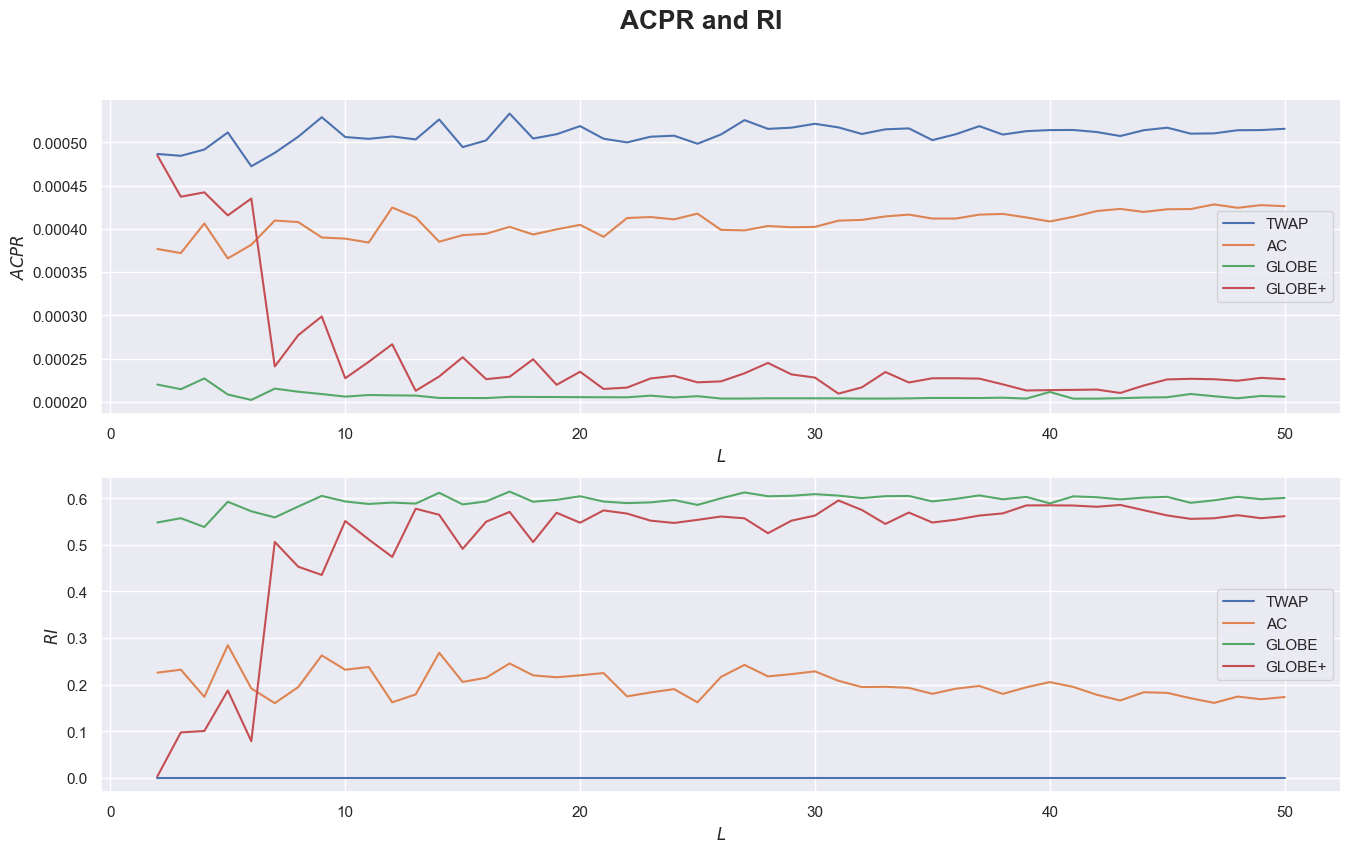

In [46]:
ACPR, RI = calc_and_plot_all_ACPR_RI(**default_params, **params)

In [ ]:
instrument = ['USD_CNH_T+1', 'USD_RUB_T+1']
date =[
     ['2022-10-04', '2022-10-12' , '2022-10-21', '2022-10-31'],
       ['2022-10-24', '2022-10-31' , '2022-11-03', '2022-11-10']
]

start_names = []
files = []

for j in range(8):
    files.append( 'optexec/' + (instrument[j//4] + '__'+ date[j//4][j % 4] +'_PQ_'+ 'ask.tsv',
                        'optexec/' + instrument[j//4] + '__'+ date[j//4][j % 4] +'_PQ_'+ 'bid.tsv' ) )
    start_names.appned(instrument[j//4] + ' ' + date[j//4][j % 4])




for file1, file2, start_name in zip(files, start_names):

    filename = start_name + ' ' + str(T) + ' ' + str(W[0]) + '.pdf'

    title = None

    params_GLOBE = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma, 'W_max': W_max, 'K': K}
    params_GLOBE_plus = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma, 'W_max': W_max, 'K': K}
    params_AC = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma}
    params_TWAP = {}

    default_params = {'T': T, 'W': W, 'start': start, 'stop': stop, 'num': num,
                    'skip': skip, 'rounds_for_est': rounds_for_est, 'file1': file1, 'file2': file2,
                    'filename': filename, 'title': title}
    params = {'TWAP': params_TWAP, 'AC': params_AC, 'GLOBE': params_GLOBE, 'GLOBE+': params_GLOBE_plus}

    ACPR, RI = calc_and_plot_all_ACPR_RI(**default_params, **params)